<a href="https://colab.research.google.com/github/Jarnoesse/IA-AGN-with-ML/blob/main/classifier_regressor_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data importation
This section was taken from Pedro Ferreira's notebook

In [1]:
#import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, plot_confusion_matrix, classification_report, explained_variance_score

from pandas.plotting import scatter_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

import missingno as msno

plt.style.use('seaborn')


import os.path

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#download datasets
table_des_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_DES_specZ_milliquas_basicFeatures.csv'
table_des_cat = Table.read(table_des_catalogue_URL)

des_df = table_des_cat.to_pandas()

table_ps_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_PS_specZ_milliquas_basicFeatures.csv'
table_ps_cat = Table.read(table_ps_catalogue_URL)

ps_df = table_ps_cat.to_pandas()

table_sm_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv'
table_sm_cat = Table.read(table_sm_catalogue_URL)

sm_df = table_sm_cat.to_pandas()

In [3]:
#feature preparation for the first dataset
des_df['W1-W2'] = des_df['W1MAG']-des_df['W2MAG']
des_df['J-KS'] = des_df['J_VISTA']-des_df['KS_VISTA']
des_df['KS-W1'] = des_df['KS_VISTA']-des_df['W1MAG']
des_df['G-R'] = des_df['MAG_G']-des_df['MAG_R']
des_df['R-Z'] = des_df['MAG_R']-des_df['MAG_Z']
des_df['Z-J'] = des_df['MAG_Z']-des_df['J_VISTA']
des_df['G-RadioR'] = des_df['MAG_G']-des_df['flux_int']
des_df['W2-RadioR'] = des_df['W2MAG']-des_df['flux_int']

#feature preparation for the second dataset
ps_df['W1-W2'] = ps_df['W1MAG']-ps_df['W2MAG']
ps_df['J-KS'] = ps_df['J_VISTA']-ps_df['KS_VISTA']
ps_df['KS-W1'] = ps_df['KS_VISTA']-ps_df['W1MAG']
ps_df['G-R'] = ps_df['MAG_G']-ps_df['MAG_R']
ps_df['R-Z'] = ps_df['MAG_R']-ps_df['MAG_Z']
ps_df['Z-J'] = ps_df['MAG_Z']-ps_df['J_VISTA']
ps_df['G-RadioR'] = ps_df['MAG_G']-ps_df['flux_int']
ps_df['W2-RadioR'] = ps_df['W2MAG']-ps_df['flux_int']

#feature preparation for the third dataset
sm_df['W1-W2'] = sm_df['W1MAG']-sm_df['W2MAG']
sm_df['J-KS'] = sm_df['J_VISTA']-sm_df['KS_VISTA']
sm_df['KS-W1'] = sm_df['KS_VISTA']-sm_df['W1MAG']
sm_df['U-G'] = sm_df['MAG_U']-sm_df['MAG_G']
sm_df['G-R'] = sm_df['MAG_G']-sm_df['MAG_R']
sm_df['R-Z'] = sm_df['MAG_R']-sm_df['MAG_Z']
sm_df['Z-J'] = sm_df['MAG_Z']-sm_df['J_VISTA']
sm_df['G-RadioR'] = sm_df['MAG_G']-sm_df['flux_int']
sm_df['W2-RadioR'] = sm_df['W2MAG']-sm_df['flux_int']

In [4]:
#TSNE was used in the test fases of this project but never used again LOOK FOR DELETE
from sklearn.manifold import TSNE
from sklearn import preprocessing

In [5]:
#creation of the dataframe with the desired features, such features as ID or position are not important for the goals of this experiment.
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","spec_class","z_spec"]
ps_df = ps_df[attributes]

Neural Networks

Keras model

In [6]:
#import of the keras / skit-learn libraries useful for this project
from numpy import unique
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow import keras

In [7]:
df_sample = ps_df.dropna() #creating the sample dataframe dropping the NaN columns from the PS dataframe

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
#converting the dataframe into a numpy array for better handling by Keras
dataset = df_sample[attributes].to_numpy()

Regressor

In [10]:
#defining the y test
y_test = df_sample["z_spec"].values

#converting everything to float
dataset, y_test = dataset.astype("float"), y_test.astype("float")

In [11]:
n_features = dataset.shape[1]

#splitting the train and the test set
X_train, X_test, y_train, y_test = train_test_split(dataset, y_test, test_size=0.33, random_state=1)


In [12]:
#defining the Keras model for regression

visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.2)(hidden1)
hidden3 = Dense(500, activation = "relu", kernel_initializer="he_normal")(dropout1)
dropout3 = Dropout(0.2)(hidden3)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.2)(hidden3)


In [13]:
#defining the out layer
out_reg = Dense(1, activation='linear')(dropout2)

#defining the model
model1 = Model(inputs=visible, outputs=[out_reg])

#compiling the Keras regression model with sparse categorical crossentropy and adam optimizer 0.02
model1.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

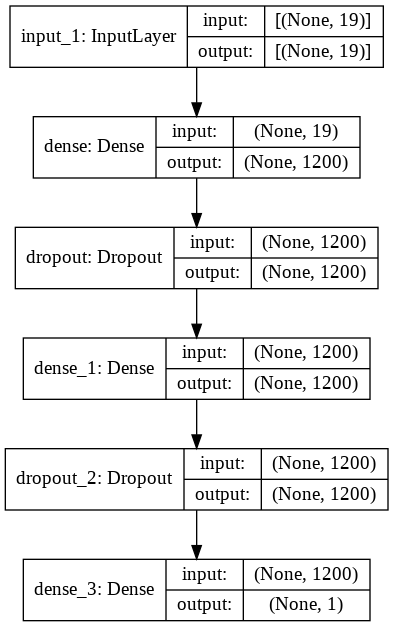

In [14]:
# plot graph of model
plot_model(model1, to_file='model.png', show_shapes=True)

In [15]:
#fitting the regression model
model1.fit(X_train,y_train, epochs=300, batch_size=32, verbose=2) # time consuming!!!!!

Epoch 1/300
282/282 - 5s - loss: 358.6090
Epoch 2/300
282/282 - 5s - loss: 7.5459
Epoch 3/300
282/282 - 5s - loss: 1.7815
Epoch 4/300
282/282 - 5s - loss: 0.4623
Epoch 5/300
282/282 - 5s - loss: 0.3327
Epoch 6/300
282/282 - 5s - loss: 0.2774
Epoch 7/300
282/282 - 5s - loss: 0.2457
Epoch 8/300
282/282 - 5s - loss: 0.2176
Epoch 9/300
282/282 - 5s - loss: 0.2007
Epoch 10/300
282/282 - 5s - loss: 0.1813
Epoch 11/300
282/282 - 5s - loss: 0.1720
Epoch 12/300
282/282 - 5s - loss: 0.1658
Epoch 13/300
282/282 - 5s - loss: 0.1620
Epoch 14/300
282/282 - 5s - loss: 0.1455
Epoch 15/300
282/282 - 5s - loss: 0.1447
Epoch 16/300
282/282 - 5s - loss: 0.1384
Epoch 17/300
282/282 - 5s - loss: 0.1399
Epoch 18/300
282/282 - 5s - loss: 0.1372
Epoch 19/300
282/282 - 5s - loss: 0.1296
Epoch 20/300
282/282 - 5s - loss: 0.1269
Epoch 21/300
282/282 - 5s - loss: 0.1237
Epoch 22/300
282/282 - 5s - loss: 0.1237
Epoch 23/300
282/282 - 5s - loss: 0.1230
Epoch 24/300
282/282 - 5s - loss: 0.1214
Epoch 25/300
282/282 - 

In [16]:
#calculating model predictions
yhat1 = model1.predict(X_test)

#evaluating the model
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.123


Skit-learn regression




In [17]:
#importing the regressor
from sklearn.linear_model import LinearRegression

In [18]:
#defining the regressor
reg = LinearRegression().fit(X_train,y_train)
yhat1 = reg.predict(X_test)

#evaluating the error
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.162


Classificator

In [19]:
#creating the sample dataframe for the classification
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]

#predicting the zspec with the previous model
df_sample["z_spec_1"] = model1.predict(df_sample[attributes].to_numpy())

#creating the final sample numpy array from the dataframe
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","z_spec_1"]
dataset = df_sample[attributes].to_numpy()

In [20]:
#defining the class array
y_class = df_sample["spec_class"].values

#seeing how many classes we have (3)
n_class = len(unique(y_class))

#converting everything to float as before
dataset,  y_class = dataset.astype('float'),y_class.astype("int")

In [21]:
#importing the oversampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
#counting how many classes we do have and how many instances
Counter(y_class)

Counter({0: 84, 1: 2751, 2: 10629})

In [23]:
#defining the number of features
n_features = dataset.shape[1]

#splitting training and test datasets
X_train, X_test, y_train_class, y_test_class = train_test_split(dataset, y_class, test_size=0.33, random_state=1)


In [24]:
#quick count of the instances in the train set
Counter(y_train_class) 

Counter({0: 67, 1: 1854, 2: 7099})

In [25]:
#defining oversampling strategy
sampling_strategy_  = {0: 3000,
                      1: 7099,
                      2: 7099}

#oversampling training set
ros = RandomOverSampler(random_state=42,sampling_strategy=sampling_strategy_)
X_train, y_train_class = ros.fit_resample(X_train, y_train_class)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
#defining keras regressor (later i'll use random forest one)
visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.3)(hidden1)
hidden3 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout3 = Dropout(0.3)(hidden3)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout3)
dropout2 = Dropout(0.3)(hidden2)

out_clas = Dense(3, activation='sigmoid')(dropout2)

In [27]:
model2 = Model(inputs=visible, outputs=[out_clas])

model2.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

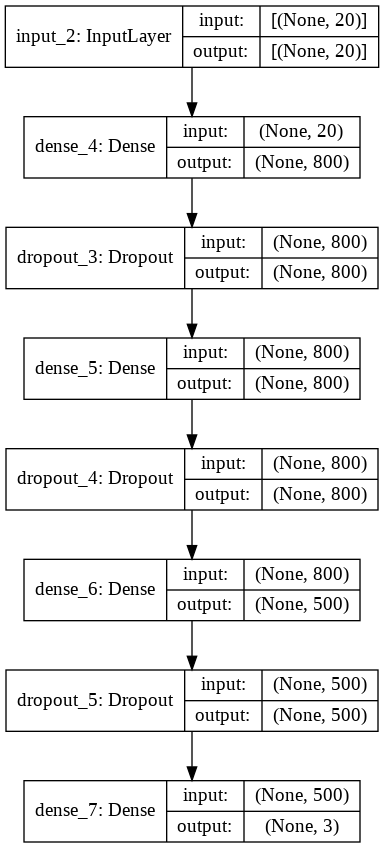

In [28]:
# plot graph of model
plot_model(model2, to_file='model.png', show_shapes=True)

In [29]:
#fitting keras classifier
model2.fit(X_train,y_train_class, epochs=1, batch_size=32, verbose=2)


538/538 - 8s - loss: 0.5881


In [30]:
#evaluating accuracy
yhat2 = model2.predict(X_test)
yhat2 = argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

Accuracy: 0.004


In [31]:
#confusion matrix
confusion_matrix(y_test_class,yhat2)

array([[  17,    0,    0],
       [ 897,    0,    0],
       [3530,    0,    0]])

Random forest

In [32]:
#importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [33]:
#defining and fitting RFClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train_class)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [34]:
#evaluating the model
yhat2 = clf.predict(X_test)
confusion_matrix(y_test_class,yhat2)

array([[  15,    1,    1],
       [   0,  732,  165],
       [   1,  197, 3332]])

data managing

In [35]:
#defining the dataset where we make the predictions
null_1 = ps_df[ps_df["z_spec"].isnull()]
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
null_1 = null_1[attributes]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7609542990>,
      dtype=object)

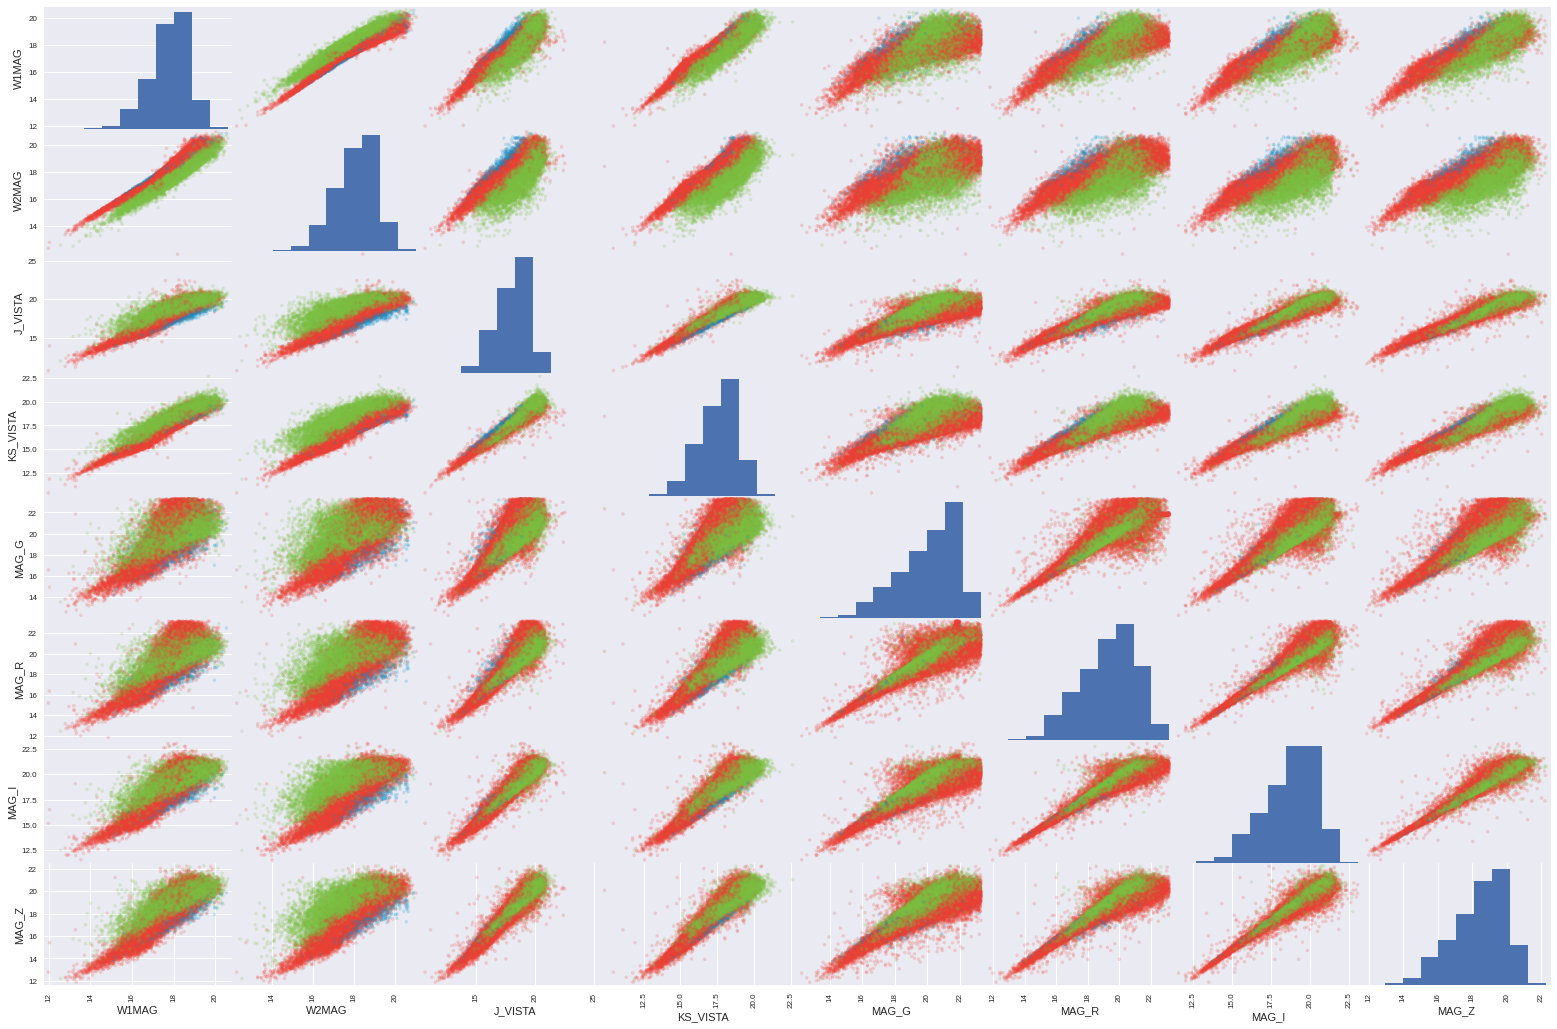

In [36]:
#predictiong the redshifts
predicted_redshifts = model1.predict(null_1.values)

#saving redshift values
null_1["z_spec"] = predicted_redshifts

#predicting the classes
predicted_classes = clf.predict(null_1.values)

#saving the predicted classes
null_1["z_class"] = predicted_classes

#defining the colormap
color_wheel = {0: "#0392cf", #blue Star
               1: "#7bc043", #green AGN
               2: "#ee4035"} #red Galaxy
colors = null_1["z_class"].map(lambda x: color_wheel.get(x))

#plotting the scatter matrices
attributes = ["W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z"]
scatter_matrix(null_1[attributes],color = colors, figsize=(27,18),alpha = 0.2)

In [37]:
#counting the classes of our prediction
null_1["z_class"].value_counts()

2    45032
1    12210
0      807
Name: z_class, dtype: int64

DES CATALOGUE

In [38]:
des_df

col0  catalogue_id  n_components  ...       Z-J  G-RadioR W2-RadioR
0            2          1542             1  ... -0.012133  1.508288  0.629288
1           10           783             1  ...  0.359090  2.769385  1.314385
2           13          1377             1  ...  0.209750  6.342734  5.829734
3           14            97             1  ... -0.076023  4.430581  3.941581
4           15            44             1  ...  0.174565 -0.311541 -1.809540
...        ...           ...           ...  ...       ...       ...       ...
175749  259245           675             1  ...  0.466638  4.139994  2.263993
175750  259246          2281             1  ...  0.537684  7.664668  5.192668
175751  259247          1484             1  ...  0.535292  4.116658 -1.227342
175752  259249          2758             1  ...  0.272680  1.851558  0.465557
175753  259250          3022             1  ...  0.946738  6.561914  3.490914

[175754 rows x 26 columns]

In [39]:
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","spec_class","z_spec"]
des_df = des_df[attributes]
df_sample = des_df.dropna()
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = df_sample[attributes].to_numpy()

In [40]:
y_sample = df_sample["z_spec"].values
dataset, y_test = dataset.astype("float"), y_test.astype("float")
n_features = dataset.shape[1]
X_train, X_test, y_train, y_test = train_test_split(dataset, y_sample, test_size=0.33, random_state=1)

In [41]:
visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.2)(hidden1)
hidden3 = Dense(500, activation = "relu", kernel_initializer="he_normal")(dropout1)
dropout3 = Dropout(0.2)(hidden3)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.2)(hidden2)

out_reg = Dense(1, activation='linear')(dropout2)

model1 = Model(inputs=visible, outputs=[out_reg])

model1.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

In [42]:
model1.fit(X_train,y_train, epochs=300, batch_size=32, verbose=2)

Epoch 1/300
263/263 - 3s - loss: 133.5061
Epoch 2/300
263/263 - 2s - loss: 1.8554
Epoch 3/300
263/263 - 2s - loss: 0.4170
Epoch 4/300
263/263 - 2s - loss: 0.2524
Epoch 5/300
263/263 - 2s - loss: 0.2086
Epoch 6/300
263/263 - 2s - loss: 0.1706
Epoch 7/300
263/263 - 2s - loss: 0.1557
Epoch 8/300
263/263 - 2s - loss: 0.1420
Epoch 9/300
263/263 - 2s - loss: 0.1343
Epoch 10/300
263/263 - 2s - loss: 0.1295
Epoch 11/300
263/263 - 2s - loss: 0.1217
Epoch 12/300
263/263 - 2s - loss: 0.1189
Epoch 13/300
263/263 - 2s - loss: 0.1135
Epoch 14/300
263/263 - 2s - loss: 0.1102
Epoch 15/300
263/263 - 2s - loss: 0.1098
Epoch 16/300
263/263 - 2s - loss: 0.1073
Epoch 17/300
263/263 - 2s - loss: 0.1061
Epoch 18/300
263/263 - 2s - loss: 0.1020
Epoch 19/300
263/263 - 2s - loss: 0.1004
Epoch 20/300
263/263 - 2s - loss: 0.0986
Epoch 21/300
263/263 - 2s - loss: 0.0978
Epoch 22/300
263/263 - 2s - loss: 0.1005
Epoch 23/300
263/263 - 2s - loss: 0.1001
Epoch 24/300
263/263 - 2s - loss: 0.1013
Epoch 25/300
263/263 - 

In [43]:
yhat1 = model1.predict(X_test)
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.098


In [44]:
reg = LinearRegression().fit(X_train,y_train)

yhat1 = reg.predict(X_test)

error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.185


In [45]:
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
df_sample["z_spec_1"] = model1.predict(df_sample[attributes].to_numpy())
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","z_spec_1"]
dataset = df_sample[attributes].to_numpy()

In [46]:
y_class = df_sample["spec_class"].values
n_class = len(unique(y_class))
dataset,  y_class = dataset.astype('float'),y_class.astype("int")

In [47]:
n_features = dataset.shape[1]
X_train, X_test, y_train_class, y_test_class = train_test_split(dataset, y_class, test_size=0.33, random_state=1)


In [48]:
Counter(y_train_class)

Counter({0: 46, 1: 1251, 2: 7096})

In [49]:
sampling_strategy_  = {0: 2000,
                      1: 5096,
                      2: 7096}

ros = RandomOverSampler(random_state=42,sampling_strategy=sampling_strategy_)
X_train, y_train_class = ros.fit_resample(X_train, y_train_class)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [50]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train_class)
yhat2 = clf.predict(X_test)

In [51]:
confusion_matrix(y_test_class,yhat2)

array([[  11,    2,   10],
       [   0,  507,  103],
       [   3,  138, 3361]])

In [52]:
null_2 = ps_df[des_df["z_spec"].isnull()]
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
null_2 = null_2[attributes]

predicted_redshifts = model1.predict(null_2.values)

null_2["z_spec"] = predicted_redshifts

predicted_classes = clf.predict(null_2.values)

null_2["z_class"] = predicted_classes

color_wheel = {0: "#0392cf", #blue Star
               1: "#7bc043", #green AGN
               2: "#ee4035"} #red Galaxy
colors = null_2["z_class"].map(lambda x: color_wheel.get(x))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [53]:
null_2

flux_int  flux_peak    MAG_I  ...  W2-RadioR    z_spec  z_class
3      12.600692  12.604439  20.0435  ...   6.708308  2.244998        1
4      15.417818  15.128676  18.3317  ...   2.873182  0.195203        2
5      14.552652  14.587673  18.2139  ...   2.617348  1.161429        1
8      13.793266  13.862125  19.9381  ...   5.829734  3.026994        1
9      13.474419  13.774631  18.0120  ...   3.941581  1.738350        1
...          ...        ...      ...  ...        ...       ...      ...
71508  13.890164  13.856373  18.9779  ...   3.836835  1.480148        1
71509  13.580781  13.540902  17.5284  ...   3.828219  0.231700        1
71510  13.920274  13.833769  18.3550  ...   2.718726  0.560426        1
71511  15.166006  15.044805  17.6677  ...   2.263993  0.232918        2
71512  16.244485  15.515209  18.5213  ...   1.133514  1.202244        1

[64649 rows x 16 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75fc620610>,
      dtype=object)

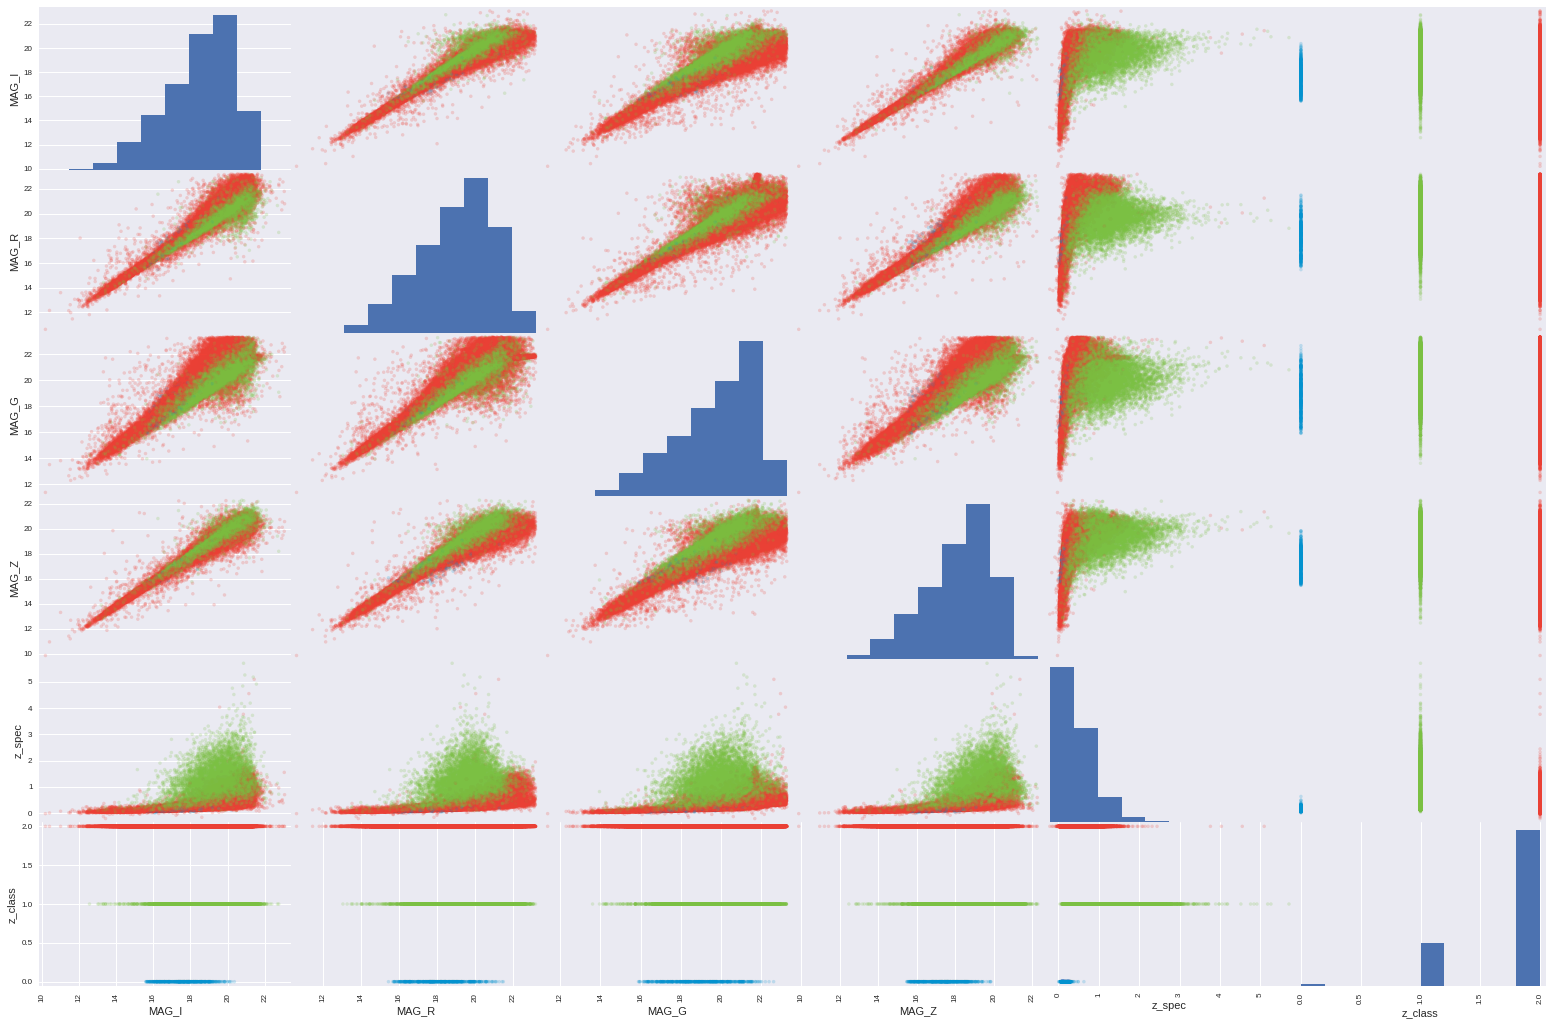

In [54]:
attributes = ["MAG_I","MAG_R","MAG_G","MAG_Z","z_spec","z_class"]
scatter_matrix(null_2[attributes],color = colors, figsize=(27,18),alpha = 0.2)

In [55]:
null_2["z_class"].value_counts()

2    50289
1    13855
0      505
Name: z_class, dtype: int64

Skymapper catalogue

In [56]:
sm_df

col0  catalogue_id  n_components  ...       Z-J  G-RadioR W2-RadioR
0           0            54             1  ...  0.228577 -0.481021 -1.785920
1           2          1542             1  ...  0.158867  1.708288  0.629288
2           3          2301             2  ...  0.031107  8.346919  5.999919
3           5           833             1  ...  1.255400  3.690282  2.873182
4           6            56             1  ...  1.014828 -3.077155 -4.934255
...       ...           ...           ...  ...       ...       ...       ...
92008  259247          1484             1  ...  0.797292  2.904858 -1.227342
92009  259248          2345             1  ...  0.094267  2.053515  1.133514
92010  259249          2758             1  ...  0.321680  1.978558  0.465557
92011  259250          3022             1  ...  1.002738  6.543914  3.490914
92012  259251            54             1  ...  0.862995 -1.058730 -3.556430

[92013 rows x 28 columns]

In [57]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","spec_class","z_spec"]
sm_df = sm_df[attributes]
df_sample = sm_df.dropna()
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = df_sample[attributes].to_numpy()

In [58]:
y_test = df_sample["z_spec"].values
dataset, y_test = dataset.astype("float"), y_test.astype("float")
n_features = dataset.shape[1]
X_train, X_test, y_train, y_test = train_test_split(dataset, y_test, test_size=0.33, random_state=1)

visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.2)(hidden1)
hidden3 = Dense(500, activation = "relu", kernel_initializer="he_normal")(dropout1)
dropout3 = Dropout(0.2)(hidden3)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.2)(hidden2)

out_reg = Dense(1, activation='linear')(dropout2)

model1 = Model(inputs=visible, outputs=[out_reg])

model1.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

In [59]:
model1.fit(X_train,y_train, epochs=300, batch_size=32, verbose=2)

Epoch 1/300
308/308 - 3s - loss: 73.9458
Epoch 2/300
308/308 - 3s - loss: 0.4364
Epoch 3/300
308/308 - 3s - loss: 0.1302
Epoch 4/300
308/308 - 3s - loss: 0.1057
Epoch 5/300
308/308 - 3s - loss: 0.0946
Epoch 6/300
308/308 - 3s - loss: 0.0819
Epoch 7/300
308/308 - 3s - loss: 0.0803
Epoch 8/300
308/308 - 3s - loss: 0.0707
Epoch 9/300
308/308 - 3s - loss: 0.0662
Epoch 10/300
308/308 - 3s - loss: 0.0621
Epoch 11/300
308/308 - 3s - loss: 0.0612
Epoch 12/300
308/308 - 3s - loss: 0.0574
Epoch 13/300
308/308 - 3s - loss: 0.0569
Epoch 14/300
308/308 - 3s - loss: 0.0536
Epoch 15/300
308/308 - 3s - loss: 0.0509
Epoch 16/300
308/308 - 3s - loss: 0.0513
Epoch 17/300
308/308 - 3s - loss: 0.0518
Epoch 18/300
308/308 - 3s - loss: 0.0524
Epoch 19/300
308/308 - 3s - loss: 0.0504
Epoch 20/300
308/308 - 3s - loss: 0.0502
Epoch 21/300
308/308 - 3s - loss: 0.0449
Epoch 22/300
308/308 - 3s - loss: 0.0513
Epoch 23/300
308/308 - 3s - loss: 0.0487
Epoch 24/300
308/308 - 3s - loss: 0.0515
Epoch 25/300
308/308 - 3

In [60]:
yhat1 = model1.predict(X_test)
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.053


In [61]:
reg = LinearRegression().fit(X_train,y_train)

yhat1 = reg.predict(X_test)

error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.088


In [62]:
df_sample

flux_int  flux_peak   W1MAG  ...  W2-RadioR  spec_class  z_spec
1      15.087712  15.005931  15.582  ...   0.629288           1  0.0620
2       8.276081   8.479472  14.661  ...   5.999919           1  0.3910
3      15.417818  15.128676  17.898  ...   2.873182           1  0.2710
6      11.733012  11.823480  17.985  ...   6.229988           1  3.0460
7      14.791615  15.142908  16.441  ...   1.314385           1  0.7230
...          ...        ...     ...  ...        ...         ...     ...
91997  12.006168  12.000925  18.121  ...   5.988832           1  2.6340
91998  21.514394  17.862567  18.026  ...  -4.311393           1  1.3218
92000  13.113121  13.132223  16.787  ...   3.411879           1  0.5640
92001  11.578844  12.868261  17.047  ...   5.050156           1  0.5860
92003  13.890164  13.856373  18.082  ...   3.836835           1  0.9630

[14699 rows x 21 columns]

In [63]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
df_sample["z_spec_1"] = model1.predict(df_sample[attributes].to_numpy())
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = df_sample[attributes].to_numpy()

y_class = df_sample["spec_class"].values 
n_class = len(unique(y_class))
dataset,  y_class = dataset.astype('float'),y_class.astype("int")

n_features = dataset.shape[1]
X_train, X_test, y_train_class, y_test_class = train_test_split(dataset, y_class, test_size=0.33, random_state=1)

sampling_strategy_  = {0: 2000,
                      1: 4000,
                      2: 8831}
ros = RandomOverSampler(random_state=42,sampling_strategy=sampling_strategy_)
X_train, y_train_class = ros.fit_resample(X_train, y_train_class)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [64]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train_class)
yhat2 = clf.predict(X_test)

confusion_matrix(y_test_class,yhat2)

array([[  26,    1,    5],
       [   0,  279,  159],
       [   1,  167, 4213]])

In [65]:
null_3 = sm_df[des_df["z_spec"].isnull()]
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
null_3 = null_3[attributes]

predicted_redshifts = model1.predict(null_3.values)

null_3["z_spec"] = predicted_redshifts

predicted_classes = clf.predict(null_3[attributes].values)

null_3["z_class"] = predicted_classes

color_wheel = {0: "#0392cf", #blue Star
               1: "#7bc043", #green AGN
               2: "#ee4035"} #red Galaxy
colors = null_3["z_class"].map(lambda x: color_wheel.get(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75f4e46d90>,
      dtype=object)

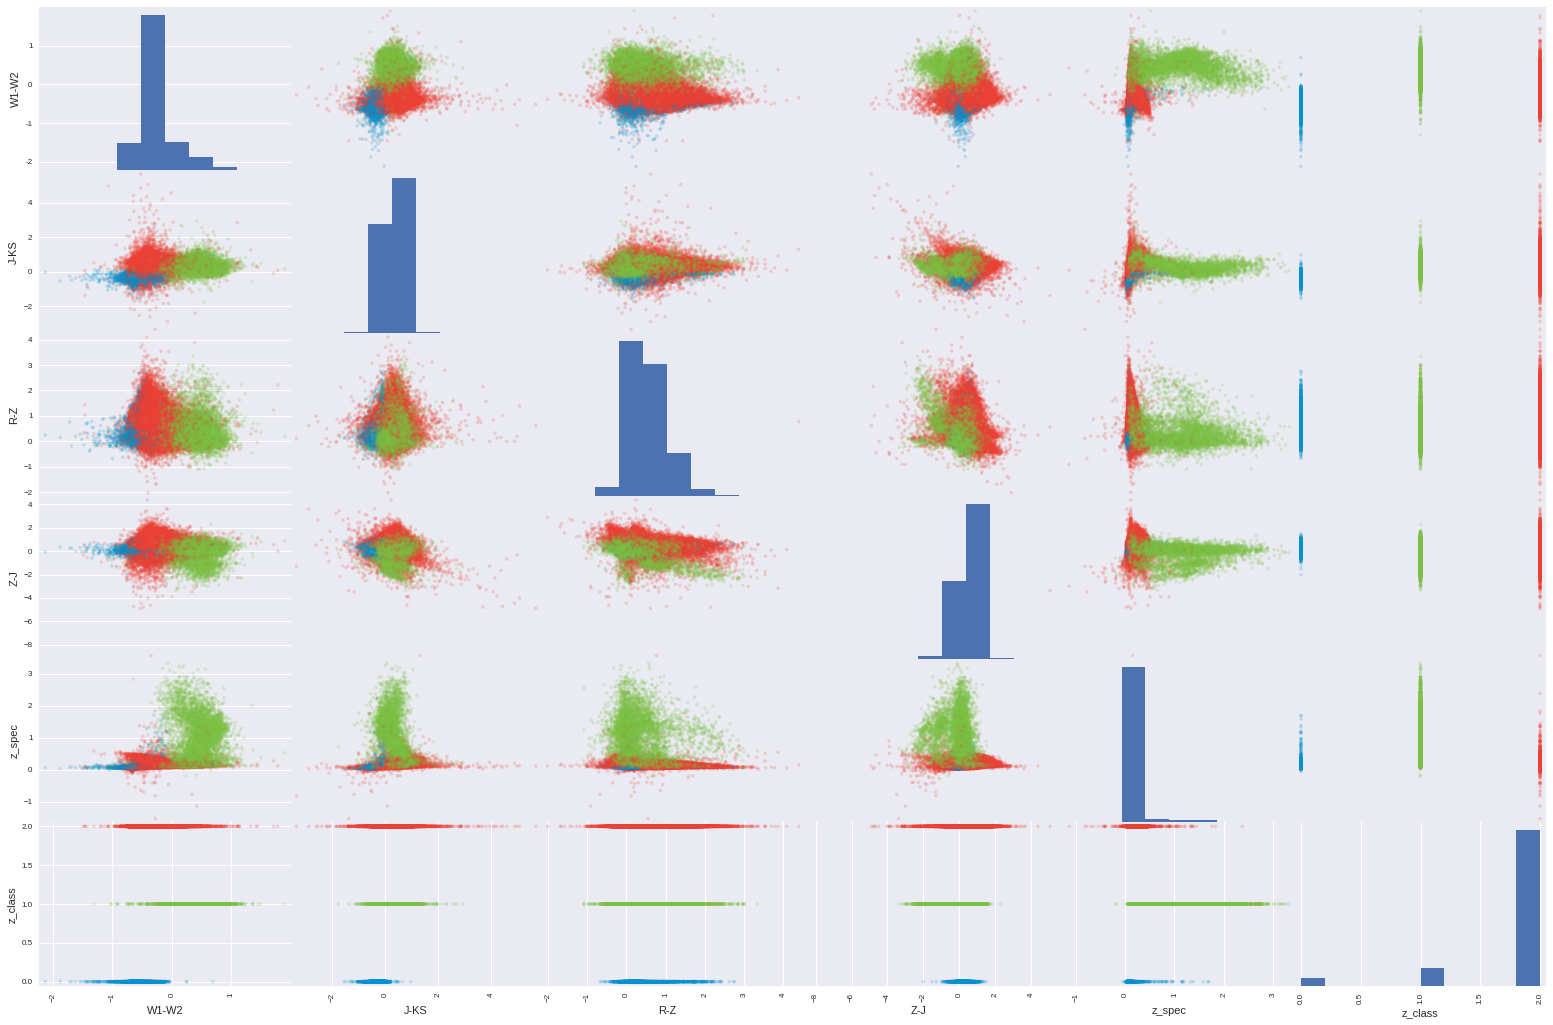

In [66]:
attributes = ["W1-W2","J-KS","R-Z","Z-J","z_spec","z_class"]
scatter_matrix(null_3[attributes],color = colors, figsize=(27,18),alpha = 0.2)

In [67]:
null_3["z_class"].value_counts()

2    73025
1     8193
0     3564
Name: z_class, dtype: int64

In [68]:
plt.hist(null_1["z_spec"].values, log = True)

(array([1.7730e+03, 3.8200e+04, 1.4858e+04, 2.0290e+03, 6.8700e+02,
        3.3700e+02, 1.2400e+02, 3.1000e+01, 9.0000e+00, 1.0000e+00]),
 array([-0.28858015,  0.10165343,  0.49188703,  0.8821206 ,  1.2723542 ,
         1.6625878 ,  2.0528214 ,  2.443055  ,  2.8332884 ,  3.2235222 ,
         3.6137557 ], dtype=float32),
 <a list of 10 Patch objects>)

(array([3.5474e+04, 2.1555e+04, 5.7150e+03, 1.3170e+03, 4.4000e+02,
        1.0800e+02, 2.4000e+01, 8.0000e+00, 5.0000e+00, 3.0000e+00]),
 array([-0.20727253,  0.3838802 ,  0.9750329 ,  1.5661856 ,  2.1573384 ,
         2.748491  ,  3.3396437 ,  3.9307964 ,  4.5219493 ,  5.113102  ,
         5.7042546 ], dtype=float32),
 <a list of 10 Patch objects>)

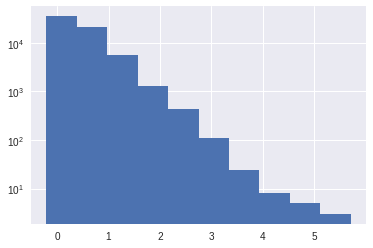

In [69]:
plt.hist(null_2["z_spec"].values,log=True)

(array([2.0000e+00, 4.0000e+00, 2.7000e+01, 7.9866e+04, 1.7940e+03,
        1.4530e+03, 1.0470e+03, 4.1700e+02, 1.5300e+02, 1.9000e+01]),
 array([-1.5265287 , -1.0416071 , -0.5566855 , -0.07176389,  0.41315773,
         0.89807934,  1.383001  ,  1.8679225 ,  2.3528442 ,  2.8377657 ,
         3.3226874 ], dtype=float32),
 <a list of 10 Patch objects>)

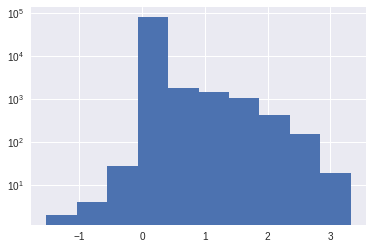

In [70]:
plt.hist(null_3["z_spec"].values,log = True)

Luminosity


PS


In [100]:
limit_flux = 0.75  # mJy, 3 x 0.25 mJy
alpha = -0.8

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc,Tcmb0 = 2.725*u.K,Om0=0.3)

In [101]:
radio_flux_AB = null_1['flux_int'].copy().values * u.ABmag
radio_flux_mJy = radio_flux_AB.to(u.mJy)  #1mJy = 1e-29 Wm-2Hz-1
red = null_1['z_spec'].copy().values

null_1['flux_int_mJy'] = radio_flux_mJy.value

filter_PS = np.array(null_1.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(null_1.loc[:, 'z_class'] != 0)

ps_with_L = null_1.loc[filter_PS]
lum_dist = cosmo.luminosity_distance(ps_with_L.loc[:,'z_spec']).to(u.m).value

radio_flx_PS_14  = (ps_with_L.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha

luminosity_PS   = 4 * np.pi * lum_dist**2 * radio_flx_PS_14 * 1e-3  * 1e-26 /\
                     (1 + ps_with_L.loc[:, 'z_spec'])**(1 + alpha)  # in W/Hz

ps_with_L['luminosity'] = luminosity_PS
ps_with_L['dist'] = lum_dist
ps_with_L['flux_int_mJy_14'] = radio_flx_PS_14

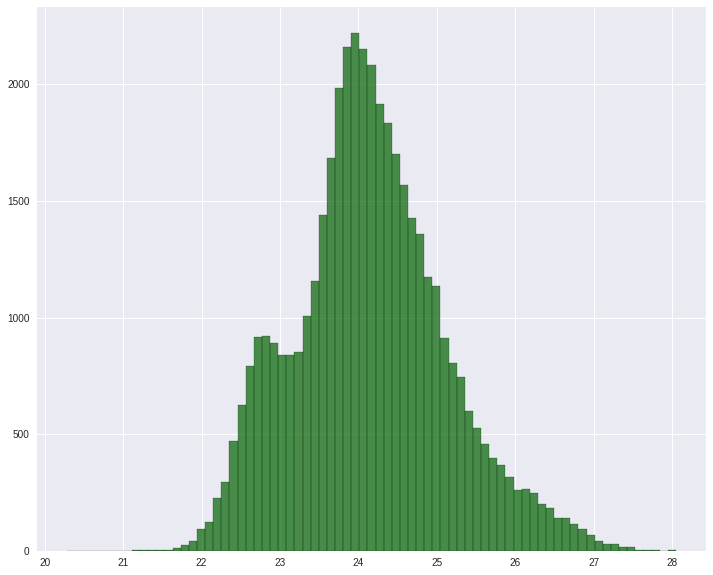

In [102]:
fig             = plt.figure(figsize=(12,10))

plt.hist(np.array(np.log10(ps_with_L['luminosity'])),bins=75,color = 'DarkGreen',ec='black',alpha =0.7)
plt.show()

In [103]:
t = 0
tot = 0

for i in range(len(np.array(ps_with_L['z_class']))):
  if np.array(ps_with_L['z_class'])[i] == 2 and np.array(ps_with_L['luminosity'])[i] > 1e25:
    t+=1
    tot +=1
  elif np.array(ps_with_L['z_class'])[i] == 2:
    tot+=1

trueperc = t/tot

print(trueperc)

0.10224589866214662


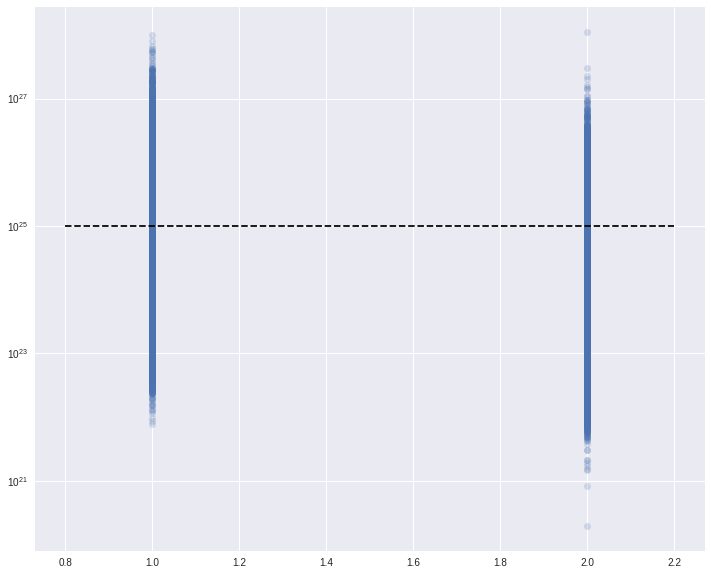

In [104]:
fig             = plt.figure(figsize=(12,10))

plt.plot(np.array(ps_with_L['z_class']),np.array(ps_with_L['luminosity']),marker='o',ls='',alpha=0.2)
plt.yscale('log')
plt.plot([0.8,1,2,2.2],[1e25,1e25,1e25,1e25], ls='--',color = 'black')
plt.show()

In [105]:
ps_with_L_changed = ps_with_L.copy()

filt_class_lum_PS = np.array(ps_with_L_changed['luminosity'] > 1e25)

ps_with_L_changed.loc[:, 'z_class'].mask(filt_class_lum_PS, other=1, inplace=True)

In [106]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import mpl_scatter_density
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report
#import ppscore as pps
import seaborn as sns
#import cmasher as cmr
import colorcet as cc
import getpass
# import pacmap
# import umap
# import trimap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from sklearn_som import som
import pandas as pd
import re
#import shap
# from BorutaShap import BorutaShap
#import pycaret.regression as pyr
#import pycaret.classification as pyc
# import missingno as msno
import os
import subprocess


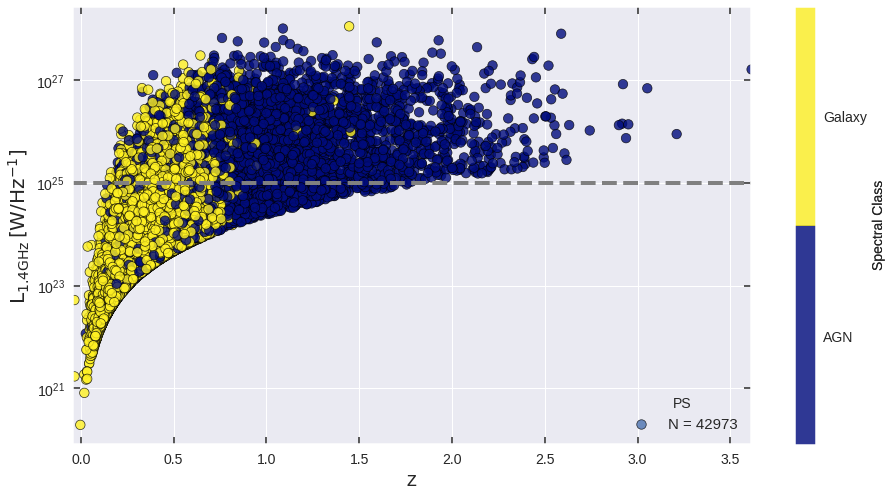

In [107]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]


fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

norm_f = mcolors.LogNorm(vmin=1e-2, vmax=1e6)

sc_p = ax1.scatter(ps_with_L.loc[:, 'z_spec'].sample(frac=1, random_state=42),\
            ps_with_L.loc[:, 'luminosity'].sample(frac=1, random_state=42),\
            c=ps_with_L.loc[:, 'z_class'].sample(frac=1, random_state=42),\
            s=90, plotnonfinite=True, linewidths=0.7, cmap=cm.get_cmap('cet_bgy', 2),\
            edgecolors='k', alpha=0.8, label=f'N = {np.sum(np.isfinite(ps_with_L.loc[:, "luminosity"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(sc_p, ticks=[1.25, 1.75])
# clb             = plt.colorbar(sc_p, ticks=[0.33, 1.0, 1.66])
# clb.set_ticks([0.33, 1.0, 1.66])
clb.ax.set_yticklabels(['AGN', 'Galaxy'])
# clb.ax.set_yticklabels(['Star', 'AGN', 'Galaxy'])
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('$\mathrm{F}_{1.4 \mathrm{GHz}}\, [\mathrm{mJy}]$', size=14, path_effects=pe2)
clb.set_label('Spectral Class', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=ps_with_L.loc[:, 'z_spec'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='PS', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

In [108]:
!pip install mpl-scatter-density

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


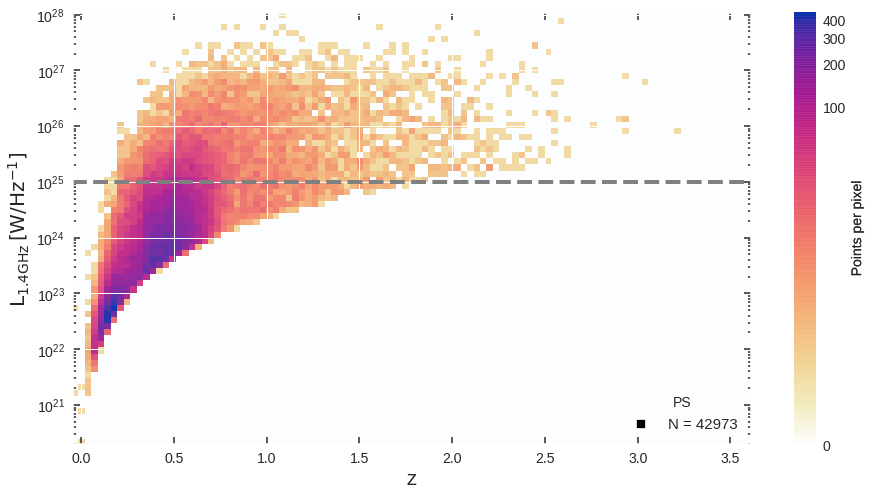

In [109]:
import mpl_scatter_density
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log', projection='scatter_density')


norm = ImageNormalize(stretch=LogStretch())

dens_1 = ax1.scatter_density(ps_with_L_changed.loc[:, 'z_spec'],\
            ps_with_L_changed.loc[:, 'luminosity'],\
            cmap=plt.get_cmap('cet_CET_L17'), zorder=0, dpi=12, norm=norm, alpha=0.93)

# dens_1 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'lum_racs'],\
#             color='b', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_2 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'lum_racs'],\
#             color='r', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_3 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'lum_racs'],\
#             color='g', zorder=0, dpi=12, norm=norm, alpha=0.53)

# False point for legend
ax1.scatter([0], [0], marker='s', s=70, c='k',\
            label=f'N = {np.sum(np.isfinite(ps_with_L_changed.loc[:, "luminosity"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('Points per pixel', size=14, path_effects=pe2)
clb.set_label('Points per pixel', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=ps_with_L_changed.loc[:, 'z_spec'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='PS', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

In [110]:
ps_with_L_changed['inter_val'] = ((1 + (1 + ps_with_L_changed.loc[:, 'z_spec'])**(1 + alpha)) / lum_dist**2) *\
         (limit_flux / ps_with_L_changed['flux_int_mJy'])

def func(z, factor):
    return (1 + z)**(1 + alpha) / cosmo.luminosity_distance(z).to(u.m).value**2 - factor

from scipy import optimize

ps_with_L_changed['max_z'] = ps_with_L_changed.apply(lambda row: optimize.root(func, row['z_spec'], args=(row['inter_val'], )).x[0], axis=1)

ps_with_L_changed.loc[:, 'max_z'].describe()

count    42973.000000
mean         1.022926
std          1.568551
min         -0.542306
25%          0.331816
50%          0.580564
75%          1.071693
max         37.619305
Name: max_z, dtype: float64

In [111]:
ps_with_L_changed['d_max_mpc'] = cosmo.luminosity_distance(ps_with_L_changed.loc[:, 'max_z']).to(u.Mpc).value   #convert z into distance in Mpc

ps_area = 3800

ps_with_L_changed['max_vol_mpc3'] = ps_area * ps_with_L_changed['d_max_mpc']**3 / 3 / 3282  # 1 square degree is 1/3282 steradians  ##vmax!

ps_with_L_changed['1/vmax'] = 1 / ps_with_L_changed['max_vol_mpc3']

ps_with_L_changed['1/vmax'].describe()

count    4.297300e+04
mean     2.151879e-09
std      2.072487e-07
min     -4.240889e-05
25%      6.933601e-12
50%      6.625385e-11
75%      4.869865e-10
max      4.882490e-06
Name: 1/vmax, dtype: float64

In [112]:
#we create the LUM bands
cut_bins_ps = [1e16,1e17,1e18,1e19,1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26, 1e27, 1e28, 1e29, 1e30]

ps_with_L_changed['cut_lums'] = pd.cut(ps_with_L_changed.loc[:, 'luminosity'],\
                                             bins=cut_bins_ps)

ps_with_L_changed.loc[:, 'cut_lums'].value_counts(sort=False)     # lum after bin

(1e+16, 1e+17]                        0
(1e+17, 1e+18]                        0
(1e+18, 1e+19]                        0
(1e+19, 9.999999999999998e+19]        0
(9.999999999999998e+19, 1e+21]        2
(1e+21, 1e+22]                      136
(1e+22, 1e+23]                     5513
(1e+23, 1e+24]                    13727
(1e+24, 1e+25]                    16116
(1e+25, 1e+26]                     5679
(1e+26, 1e+27]                     1643
(1e+27, 1e+28]                      155
(1e+28, 1e+29]                        2
(1e+29, 1e+30]                        0
Name: cut_lums, dtype: int64

In [114]:
filter_AGN_ps = np.array(ps_with_L_changed.loc[:, 'z_class'] == 1)    #separate agns and galaxies
filter_gal_ps = np.array(ps_with_L_changed.loc[:, 'z_class'] == 2)

filter_z0_ps = np.array(ps_with_L_changed.loc[:, 'z_spec'] >= 0.1) & np.array(ps_with_L_changed.loc[:, 'z_spec'] <= 0.4)  #separate the 2 redshift intervals
filter_z1_ps = np.array(ps_with_L_changed.loc[:, 'z_spec'] >= 1.0) & np.array(ps_with_L_changed.loc[:, 'z_spec'] <= 1.3)

ps_AGN_sumed_bins_z0 = ps_with_L_changed.loc[filter_AGN_ps & filter_z0_ps].groupby('cut_lums').sum()   #summing the agns and galaxies in the two redshift bins
ps_gal_sumed_bins_z0 = ps_with_L_changed.loc[filter_gal_ps & filter_z0_ps].groupby('cut_lums').sum()

ps_AGN_sumed_bins_z1 = ps_with_L_changed.loc[filter_AGN_ps & filter_z1_ps].groupby('cut_lums').sum()
ps_gal_sumed_bins_z1 = ps_with_L_changed.loc[filter_gal_ps & filter_z1_ps].groupby('cut_lums').sum()

ps_AGN_sumed_bins_z0['size'] = ps_with_L_changed.loc[filter_AGN_ps & filter_z0_ps, 'cut_lums'].value_counts(sort=False)   #these are new columns to get the size of elements in each bin that will be helpful to calculate error
ps_gal_sumed_bins_z0['size'] = ps_with_L_changed.loc[filter_gal_ps & filter_z0_ps, 'cut_lums'].value_counts(sort=False)

ps_AGN_sumed_bins_z1['size'] = ps_with_L_changed.loc[filter_AGN_ps & filter_z1_ps, 'cut_lums'].value_counts(sort=False)
ps_gal_sumed_bins_z1['size'] = ps_with_L_changed.loc[filter_gal_ps & filter_z1_ps, 'cut_lums'].value_counts(sort=False)

fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.errorbar(np.log10(cut_bins_ps[1::]), np.log10(ps_AGN_sumed_bins_z0.loc[:, '1/vmax'].to_numpy()),\
         xerr=0.5, yerr=np.log10(1/ps_AGN_sumed_bins_z0.loc[:, 'size'].to_numpy()), marker='o',\
          ls='', label='PS AGN', ms=10, color='royalblue', alpha=0.8)
ax1.errorbar(np.log10(cut_bins_ps[1::]), np.log10(ps_gal_sumed_bins_z0.loc[:, '1/vmax'].to_numpy()),\
         xerr=0.5, yerr=np.log10(1/ps_gal_sumed_bins_z0.loc[:, 'size'].to_numpy()), marker='s',\
          ls='', label='PS Galaxies', ms=10, color='tomato', alpha=0.8)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$\log{}\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
ax1.set_ylabel('$\log{}\mathrm{\phi}\, [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=20, title='0.1 < z < 0.4', title_fontsize=16)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:3324: RuntimeWarning: invalid value encountered in double_scalars
  high = [v + e for v, e in zip(data, b)]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


DES

In [116]:
radio_flux_AB = null_2['flux_int'].copy().values * u.ABmag
radio_flux_mJy = radio_flux_AB.to(u.mJy)  #1mJy = 1e-29 Wm-2Hz-1
red = null_2['z_spec'].copy().values

null_2['flux_int_mJy'] = radio_flux_mJy.value

filter_PS = np.array(null_2.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(null_2.loc[:, 'z_class'] != 0)

ps_with_L = null_2.loc[filter_PS]
lum_dist = cosmo.luminosity_distance(ps_with_L.loc[:,'z_spec']).to(u.m).value

radio_flx_PS_14  = (ps_with_L.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha

luminosity_PS   = 4 * np.pi * lum_dist**2 * radio_flx_PS_14 * 1e-3  * 1e-26 /\
                     (1 + ps_with_L.loc[:, 'z_spec'])**(1 + alpha)  # in W/Hz

ps_with_L['luminosity'] = luminosity_PS
ps_with_L['dist'] = lum_dist
ps_with_L['flux_int_mJy_14'] = radio_flx_PS_14

In [117]:
t = 0
tot = 0

for i in range(len(np.array(ps_with_L['z_class']))):
  if np.array(ps_with_L['z_class'])[i] == 2 and np.array(ps_with_L['luminosity'])[i] > 1e25:
    t+=1
    tot +=1
  elif np.array(ps_with_L['z_class'])[i] == 2:
    tot+=1

trueperc = t/tot

print(trueperc)

0.11131656804733728


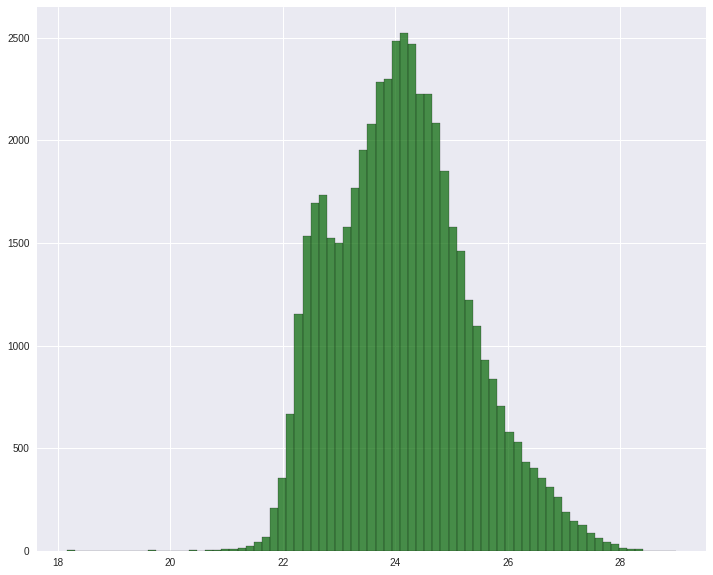

In [118]:
fig             = plt.figure(figsize=(12,10))

plt.hist(np.array(np.log10(ps_with_L['luminosity'])),bins=75,color = 'DarkGreen',ec='black',alpha =0.7)
plt.show()

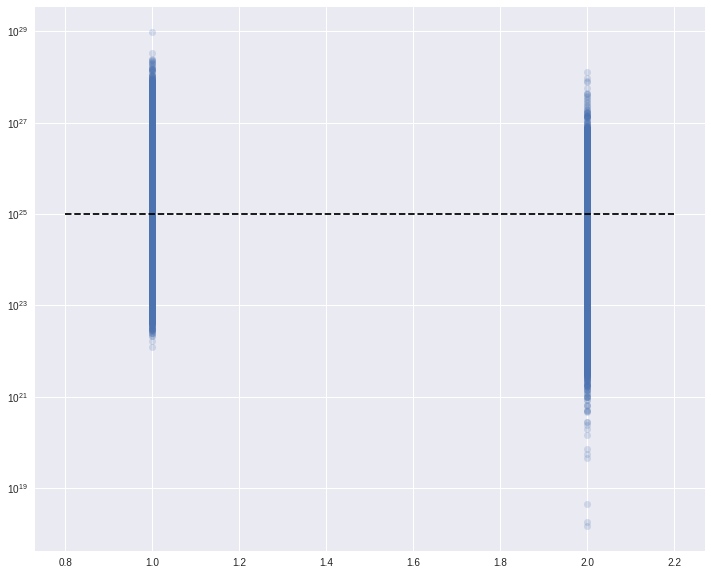

In [119]:
fig             = plt.figure(figsize=(12,10))

plt.plot(np.array(ps_with_L['z_class']),np.array(ps_with_L['luminosity']),marker='o',ls='',alpha=0.2)
plt.yscale('log')
plt.plot([0.8,1,2,2.2],[1e25,1e25,1e25,1e25], ls='--',color = 'black')
plt.show()

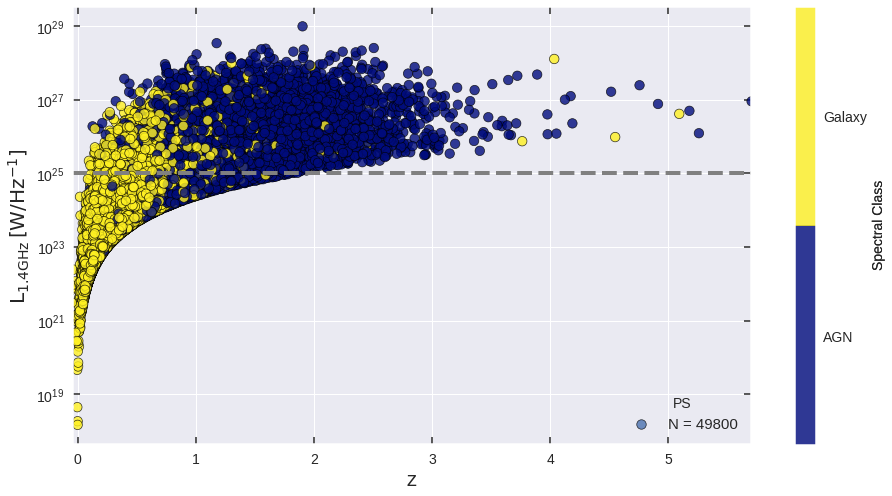

In [120]:
ps_with_L_changed = ps_with_L.copy()

filt_class_lum_PS = np.array(ps_with_L_changed['luminosity'] > 1e25)

ps_with_L_changed.loc[:, 'z_class'].mask(filt_class_lum_PS, other=1, inplace=True)

pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]


fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

norm_f = mcolors.LogNorm(vmin=1e-2, vmax=1e6)

sc_p = ax1.scatter(ps_with_L.loc[:, 'z_spec'].sample(frac=1, random_state=42),\
            ps_with_L.loc[:, 'luminosity'].sample(frac=1, random_state=42),\
            c=ps_with_L.loc[:, 'z_class'].sample(frac=1, random_state=42),\
            s=90, plotnonfinite=True, linewidths=0.7, cmap=cm.get_cmap('cet_bgy', 2),\
            edgecolors='k', alpha=0.8, label=f'N = {np.sum(np.isfinite(ps_with_L.loc[:, "luminosity"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(sc_p, ticks=[1.25, 1.75])
# clb             = plt.colorbar(sc_p, ticks=[0.33, 1.0, 1.66])
# clb.set_ticks([0.33, 1.0, 1.66])
clb.ax.set_yticklabels(['AGN', 'Galaxy'])
# clb.ax.set_yticklabels(['Star', 'AGN', 'Galaxy'])
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('$\mathrm{F}_{1.4 \mathrm{GHz}}\, [\mathrm{mJy}]$', size=14, path_effects=pe2)
clb.set_label('Spectral Class', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=ps_with_L.loc[:, 'z_spec'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='PS', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


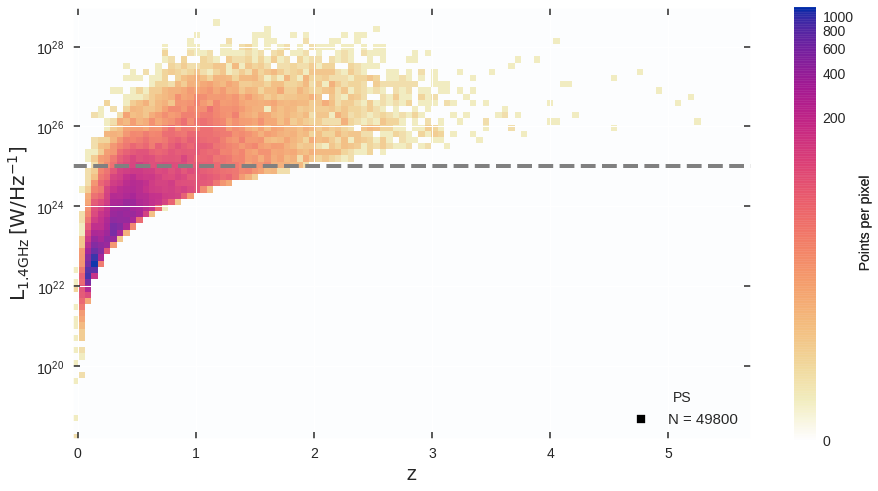

In [121]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log', projection='scatter_density')


norm = ImageNormalize(stretch=LogStretch())

dens_1 = ax1.scatter_density(ps_with_L_changed.loc[:, 'z_spec'],\
            ps_with_L_changed.loc[:, 'luminosity'],\
            cmap=plt.get_cmap('cet_CET_L17'), zorder=0, dpi=12, norm=norm, alpha=0.93)

# dens_1 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'lum_racs'],\
#             color='b', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_2 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'lum_racs'],\
#             color='r', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_3 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'lum_racs'],\
#             color='g', zorder=0, dpi=12, norm=norm, alpha=0.53)

# False point for legend
ax1.scatter([0], [0], marker='s', s=70, c='k',\
            label=f'N = {np.sum(np.isfinite(ps_with_L_changed.loc[:, "luminosity"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('Points per pixel', size=14, path_effects=pe2)
clb.set_label('Points per pixel', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=ps_with_L_changed.loc[:, 'z_spec'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='PS', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:3324: RuntimeWarning: invalid value encountered in double_scalars
  high = [v + e for v, e in zip(data, b)]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


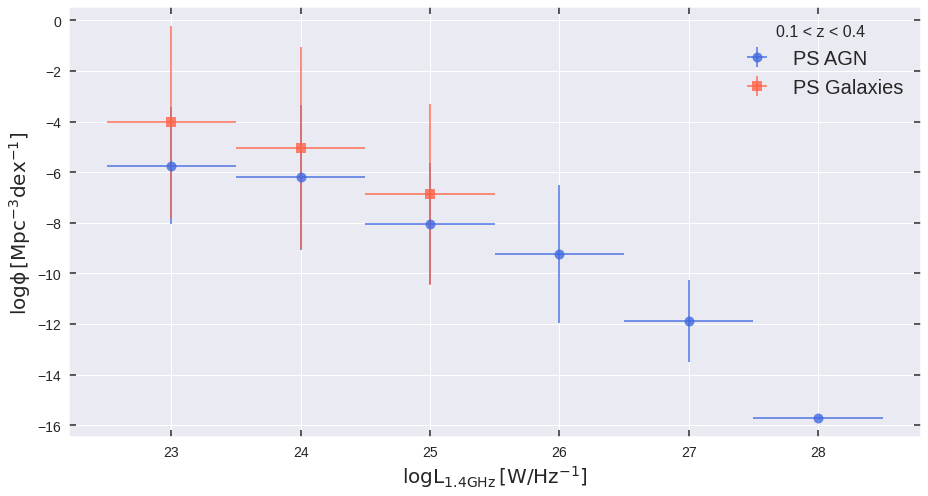

In [122]:
ps_with_L_changed['inter_val'] = ((1 + (1 + ps_with_L_changed.loc[:, 'z_spec'])**(1 + alpha)) / lum_dist**2) *\
         (limit_flux / ps_with_L_changed['flux_int_mJy'])

def func(z, factor):
    return (1 + z)**(1 + alpha) / cosmo.luminosity_distance(z).to(u.m).value**2 - factor

from scipy import optimize

ps_with_L_changed['max_z'] = ps_with_L_changed.apply(lambda row: optimize.root(func, row['z_spec'], args=(row['inter_val'], )).x[0], axis=1)

ps_with_L_changed.loc[:, 'max_z'].describe()

ps_with_L_changed['d_max_mpc'] = cosmo.luminosity_distance(ps_with_L_changed.loc[:, 'max_z']).to(u.Mpc).value   #convert z into distance in Mpc

ps_area = 3800

ps_with_L_changed['max_vol_mpc3'] = ps_area * ps_with_L_changed['d_max_mpc']**3 / 3 / 3282  # 1 square degree is 1/3282 steradians  ##vmax!

ps_with_L_changed['1/vmax'] = 1 / ps_with_L_changed['max_vol_mpc3']

ps_with_L_changed['1/vmax'].describe()

#we create the LUM bands
cut_bins_ps = [1e16,1e17,1e18,1e19,1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26, 1e27, 1e28, 1e29, 1e30]

ps_with_L_changed['cut_lums'] = pd.cut(ps_with_L_changed.loc[:, 'luminosity'],\
                                             bins=cut_bins_ps)

ps_with_L_changed.loc[:, 'cut_lums'].value_counts(sort=False)     # lum after bin

filter_AGN_ps = np.array(ps_with_L_changed.loc[:, 'z_class'] == 1)    #separate agns and galaxies
filter_gal_ps = np.array(ps_with_L_changed.loc[:, 'z_class'] == 2)

filter_z0_ps = np.array(ps_with_L_changed.loc[:, 'z_spec'] >= 0.1) & np.array(ps_with_L_changed.loc[:, 'z_spec'] <= 0.4)  #separate the 2 redshift intervals
filter_z1_ps = np.array(ps_with_L_changed.loc[:, 'z_spec'] >= 1.0) & np.array(ps_with_L_changed.loc[:, 'z_spec'] <= 1.3)

ps_AGN_sumed_bins_z0 = ps_with_L_changed.loc[filter_AGN_ps & filter_z0_ps].groupby('cut_lums').sum()   #summing the agns and galaxies in the two redshift bins
ps_gal_sumed_bins_z0 = ps_with_L_changed.loc[filter_gal_ps & filter_z0_ps].groupby('cut_lums').sum()

ps_AGN_sumed_bins_z1 = ps_with_L_changed.loc[filter_AGN_ps & filter_z1_ps].groupby('cut_lums').sum()
ps_gal_sumed_bins_z1 = ps_with_L_changed.loc[filter_gal_ps & filter_z1_ps].groupby('cut_lums').sum()

ps_AGN_sumed_bins_z0['size'] = ps_with_L_changed.loc[filter_AGN_ps & filter_z0_ps, 'cut_lums'].value_counts(sort=False)   #these are new columns to get the size of elements in each bin that will be helpful to calculate error
ps_gal_sumed_bins_z0['size'] = ps_with_L_changed.loc[filter_gal_ps & filter_z0_ps, 'cut_lums'].value_counts(sort=False)

ps_AGN_sumed_bins_z1['size'] = ps_with_L_changed.loc[filter_AGN_ps & filter_z1_ps, 'cut_lums'].value_counts(sort=False)
ps_gal_sumed_bins_z1['size'] = ps_with_L_changed.loc[filter_gal_ps & filter_z1_ps, 'cut_lums'].value_counts(sort=False)

fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.errorbar(np.log10(cut_bins_ps[1::]), np.log10(ps_AGN_sumed_bins_z0.loc[:, '1/vmax'].to_numpy()),\
         xerr=0.5, yerr=np.log10(1/ps_AGN_sumed_bins_z0.loc[:, 'size'].to_numpy()), marker='o',\
          ls='', label='PS AGN', ms=10, color='royalblue', alpha=0.8)
ax1.errorbar(np.log10(cut_bins_ps[1::]), np.log10(ps_gal_sumed_bins_z0.loc[:, '1/vmax'].to_numpy()),\
         xerr=0.5, yerr=np.log10(1/ps_gal_sumed_bins_z0.loc[:, 'size'].to_numpy()), marker='s',\
          ls='', label='PS Galaxies', ms=10, color='tomato', alpha=0.8)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$\log{}\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
ax1.set_ylabel('$\log{}\mathrm{\phi}\, [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=20, title='0.1 < z < 0.4', title_fontsize=16)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()


Skymapper

In [123]:
radio_flux_AB = null_3['flux_int'].copy().values * u.ABmag
radio_flux_mJy = radio_flux_AB.to(u.mJy)  #1mJy = 1e-29 Wm-2Hz-1
red = null_3['z_spec'].copy().values

null_3['flux_int_mJy'] = radio_flux_mJy.value

filter_PS = np.array(null_3.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(null_3.loc[:, 'z_class'] != 0)

ps_with_L = null_3.loc[filter_PS]
lum_dist = cosmo.luminosity_distance(ps_with_L.loc[:,'z_spec']).to(u.m).value

radio_flx_PS_14  = (ps_with_L.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha

luminosity_PS   = 4 * np.pi * lum_dist**2 * radio_flx_PS_14 * 1e-3  * 1e-26 /\
                     (1 + ps_with_L.loc[:, 'z_spec'])**(1 + alpha)  # in W/Hz

ps_with_L['luminosity'] = luminosity_PS
ps_with_L['dist'] = lum_dist
ps_with_L['flux_int_mJy_14'] = radio_flx_PS_14

In [124]:
t = 0
tot = 0

for i in range(len(np.array(ps_with_L['z_class']))):
  if np.array(ps_with_L['z_class'])[i] == 2 and np.array(ps_with_L['luminosity'])[i] > 1e25:
    t+=1
    tot +=1
  elif np.array(ps_with_L['z_class'])[i] == 2:
    tot+=1

trueperc = t/tot

print(trueperc)

0.016405729513657562


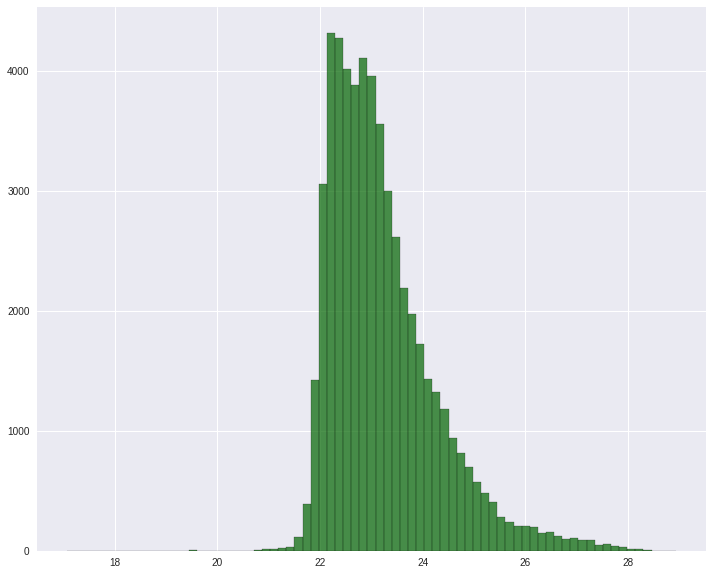

In [125]:
fig             = plt.figure(figsize=(12,10))

plt.hist(np.array(np.log10(ps_with_L['luminosity'])),bins=75,color = 'DarkGreen',ec='black',alpha =0.7)
plt.show()

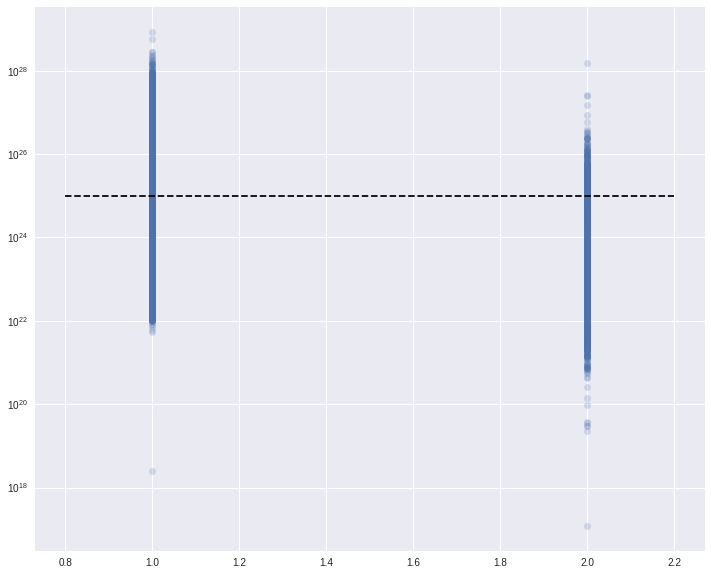

In [126]:
fig             = plt.figure(figsize=(12,10))

plt.plot(np.array(ps_with_L['z_class']),np.array(ps_with_L['luminosity']),marker='o',ls='',alpha=0.2)
plt.yscale('log')
plt.plot([0.8,1,2,2.2],[1e25,1e25,1e25,1e25], ls='--',color = 'black')
plt.show()

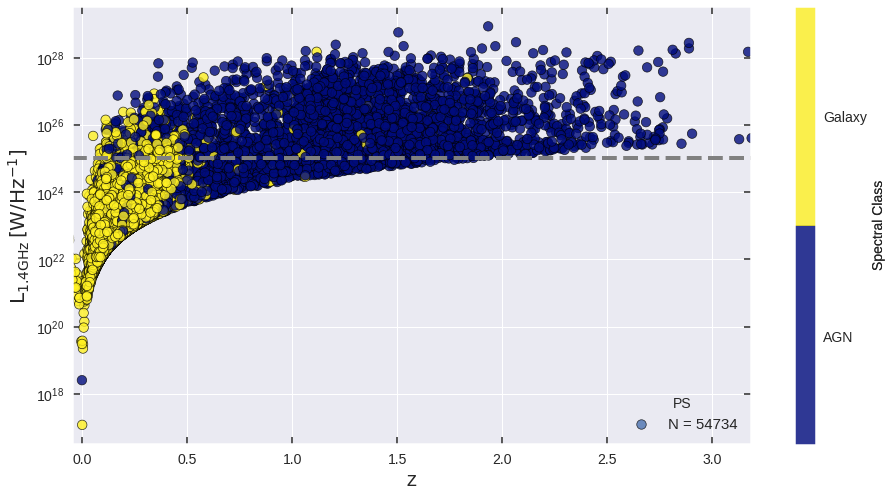

In [127]:
ps_with_L_changed = ps_with_L.copy()

filt_class_lum_PS = np.array(ps_with_L_changed['luminosity'] > 1e25)

ps_with_L_changed.loc[:, 'z_class'].mask(filt_class_lum_PS, other=1, inplace=True)

pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]


fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

norm_f = mcolors.LogNorm(vmin=1e-2, vmax=1e6)

sc_p = ax1.scatter(ps_with_L.loc[:, 'z_spec'].sample(frac=1, random_state=42),\
            ps_with_L.loc[:, 'luminosity'].sample(frac=1, random_state=42),\
            c=ps_with_L.loc[:, 'z_class'].sample(frac=1, random_state=42),\
            s=90, plotnonfinite=True, linewidths=0.7, cmap=cm.get_cmap('cet_bgy', 2),\
            edgecolors='k', alpha=0.8, label=f'N = {np.sum(np.isfinite(ps_with_L.loc[:, "luminosity"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(sc_p, ticks=[1.25, 1.75])
# clb             = plt.colorbar(sc_p, ticks=[0.33, 1.0, 1.66])
# clb.set_ticks([0.33, 1.0, 1.66])
clb.ax.set_yticklabels(['AGN', 'Galaxy'])
# clb.ax.set_yticklabels(['Star', 'AGN', 'Galaxy'])
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('$\mathrm{F}_{1.4 \mathrm{GHz}}\, [\mathrm{mJy}]$', size=14, path_effects=pe2)
clb.set_label('Spectral Class', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=ps_with_L.loc[:, 'z_spec'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='PS', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


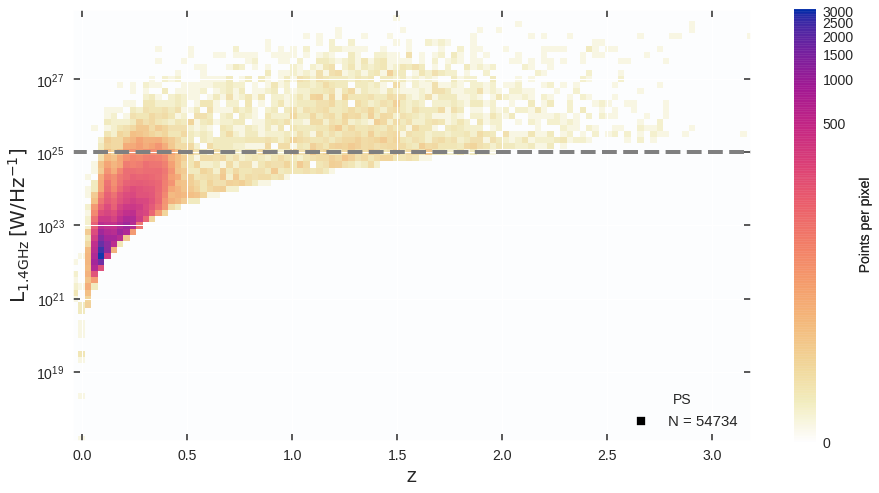

In [128]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log', projection='scatter_density')


norm = ImageNormalize(stretch=LogStretch())

dens_1 = ax1.scatter_density(ps_with_L_changed.loc[:, 'z_spec'],\
            ps_with_L_changed.loc[:, 'luminosity'],\
            cmap=plt.get_cmap('cet_CET_L17'), zorder=0, dpi=12, norm=norm, alpha=0.93)

# dens_1 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'lum_racs'],\
#             color='b', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_2 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'lum_racs'],\
#             color='r', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_3 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'lum_racs'],\
#             color='g', zorder=0, dpi=12, norm=norm, alpha=0.53)

# False point for legend
ax1.scatter([0], [0], marker='s', s=70, c='k',\
            label=f'N = {np.sum(np.isfinite(ps_with_L_changed.loc[:, "luminosity"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('Points per pixel', size=14, path_effects=pe2)
clb.set_label('Points per pixel', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=ps_with_L_changed.loc[:, 'z_spec'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='PS', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:3324: RuntimeWarning: invalid value encountered in double_scalars
  high = [v + e for v, e in zip(data, b)]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


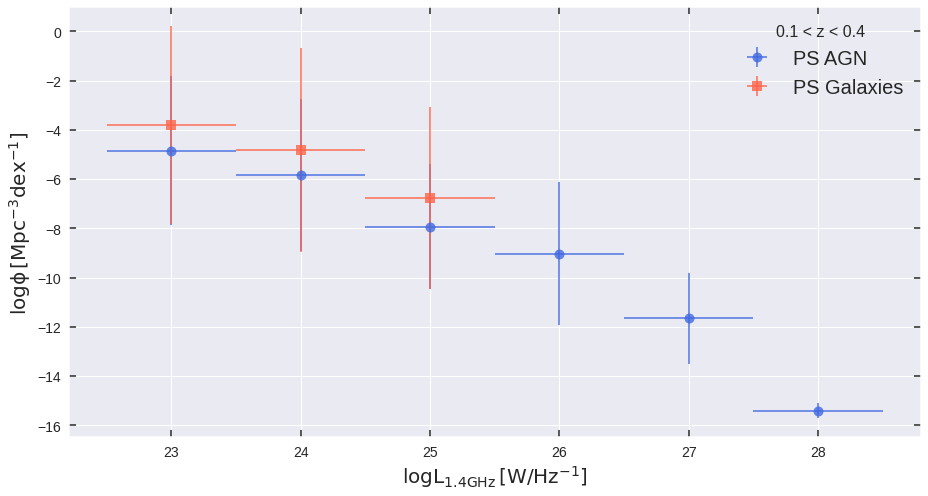

In [129]:
ps_with_L_changed['inter_val'] = ((1 + (1 + ps_with_L_changed.loc[:, 'z_spec'])**(1 + alpha)) / lum_dist**2) *\
         (limit_flux / ps_with_L_changed['flux_int_mJy'])

def func(z, factor):
    return (1 + z)**(1 + alpha) / cosmo.luminosity_distance(z).to(u.m).value**2 - factor

from scipy import optimize

ps_with_L_changed['max_z'] = ps_with_L_changed.apply(lambda row: optimize.root(func, row['z_spec'], args=(row['inter_val'], )).x[0], axis=1)

ps_with_L_changed.loc[:, 'max_z'].describe()

ps_with_L_changed['d_max_mpc'] = cosmo.luminosity_distance(ps_with_L_changed.loc[:, 'max_z']).to(u.Mpc).value   #convert z into distance in Mpc

ps_area = 3800

ps_with_L_changed['max_vol_mpc3'] = ps_area * ps_with_L_changed['d_max_mpc']**3 / 3 / 3282  # 1 square degree is 1/3282 steradians  ##vmax!

ps_with_L_changed['1/vmax'] = 1 / ps_with_L_changed['max_vol_mpc3']

ps_with_L_changed['1/vmax'].describe()

#we create the LUM bands
cut_bins_ps = [1e16,1e17,1e18,1e19,1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26, 1e27, 1e28, 1e29, 1e30]

ps_with_L_changed['cut_lums'] = pd.cut(ps_with_L_changed.loc[:, 'luminosity'],\
                                             bins=cut_bins_ps)

ps_with_L_changed.loc[:, 'cut_lums'].value_counts(sort=False)     # lum after bin

filter_AGN_ps = np.array(ps_with_L_changed.loc[:, 'z_class'] == 1)    #separate agns and galaxies
filter_gal_ps = np.array(ps_with_L_changed.loc[:, 'z_class'] == 2)

filter_z0_ps = np.array(ps_with_L_changed.loc[:, 'z_spec'] >= 0.1) & np.array(ps_with_L_changed.loc[:, 'z_spec'] <= 0.4)  #separate the 2 redshift intervals
filter_z1_ps = np.array(ps_with_L_changed.loc[:, 'z_spec'] >= 1.0) & np.array(ps_with_L_changed.loc[:, 'z_spec'] <= 1.3)

ps_AGN_sumed_bins_z0 = ps_with_L_changed.loc[filter_AGN_ps & filter_z0_ps].groupby('cut_lums').sum()   #summing the agns and galaxies in the two redshift bins
ps_gal_sumed_bins_z0 = ps_with_L_changed.loc[filter_gal_ps & filter_z0_ps].groupby('cut_lums').sum()

ps_AGN_sumed_bins_z1 = ps_with_L_changed.loc[filter_AGN_ps & filter_z1_ps].groupby('cut_lums').sum()
ps_gal_sumed_bins_z1 = ps_with_L_changed.loc[filter_gal_ps & filter_z1_ps].groupby('cut_lums').sum()

ps_AGN_sumed_bins_z0['size'] = ps_with_L_changed.loc[filter_AGN_ps & filter_z0_ps, 'cut_lums'].value_counts(sort=False)   #these are new columns to get the size of elements in each bin that will be helpful to calculate error
ps_gal_sumed_bins_z0['size'] = ps_with_L_changed.loc[filter_gal_ps & filter_z0_ps, 'cut_lums'].value_counts(sort=False)

ps_AGN_sumed_bins_z1['size'] = ps_with_L_changed.loc[filter_AGN_ps & filter_z1_ps, 'cut_lums'].value_counts(sort=False)
ps_gal_sumed_bins_z1['size'] = ps_with_L_changed.loc[filter_gal_ps & filter_z1_ps, 'cut_lums'].value_counts(sort=False)

fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.errorbar(np.log10(cut_bins_ps[1::]), np.log10(ps_AGN_sumed_bins_z0.loc[:, '1/vmax'].to_numpy()),\
         xerr=0.5, yerr=np.log10(1/ps_AGN_sumed_bins_z0.loc[:, 'size'].to_numpy()), marker='o',\
          ls='', label='PS AGN', ms=10, color='royalblue', alpha=0.8)
ax1.errorbar(np.log10(cut_bins_ps[1::]), np.log10(ps_gal_sumed_bins_z0.loc[:, '1/vmax'].to_numpy()),\
         xerr=0.5, yerr=np.log10(1/ps_gal_sumed_bins_z0.loc[:, 'size'].to_numpy()), marker='s',\
          ls='', label='PS Galaxies', ms=10, color='tomato', alpha=0.8)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$\log{}\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
ax1.set_ylabel('$\log{}\mathrm{\phi}\, [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=20, title='0.1 < z < 0.4', title_fontsize=16)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()